In [28]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from cuml.manifold import TSNE
import cupy as cp
import matplotlib.pyplot as plt

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict

# Step 1: Define your custom model constructor
def resnet50_(in_channels, n_classes, dropout=0.5, weights=None):
    model = models.resnet50(weights=weights)
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=2048, out_features=512, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=512, out_features=64, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(64),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=64, out_features=n_classes, bias=True)
    )
    return model

# Step 2: Load the .pth file and clean state_dict
pth_path = "yichen_model.pth"
checkpoint = torch.load(pth_path, map_location="cuda")

# If 'state_dict' is present, extract it
if "state_dict" in checkpoint:
    checkpoint = checkpoint["state_dict"]

# Remove 'module.' prefix if trained with DataParallel
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    new_k = k.replace("module.", "")
    new_state_dict[new_k] = v

# Step 3: Create model and load weights
model = resnet50_(in_channels=3, n_classes=17)  # Change in_channels or n_classes as per your use
model.load_state_dict(new_state_dict)
model.eval()

print("✅ Model loaded successfully.")



✅ Model loaded successfully.


In [30]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm


In [31]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device).eval()

Using device: cuda:4


In [32]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom dataset to load all PNGs
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]  # return image path for tracking


In [40]:
folder_path = "data/output/png"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = UnlabeledImageDataset(folder_path, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False,pin_memory=True,num_workers=16)

In [41]:
model.eval()
model.to("cuda:4")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [42]:
model.fc = nn.Sequential(*list(model.fc.children())[:6])

In [43]:
model.fc

Sequential(
  (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=2048, out_features=512, bias=False)
  (3): ReLU(inplace=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.5, inplace=False)
)

In [9]:
model = model.to("cuda")


In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [16]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 10
Current device: 0
Device name: NVIDIA A100 80GB PCIe


In [12]:
# next(model.parameters()).device
# print("Model is on:", next(model.parameters()).device)

Model is on: cuda:0


In [44]:
import torch
import numpy as np
from tqdm import tqdm

embeddings = []
file_names = []

with torch.no_grad():
    for inputs, paths in tqdm(loader):
        inputs = inputs.to("cuda:4")
        feats = model(inputs)
        # Forward up to avgpool
        # feats = model.conv1(inputs)
        # feats = model.bn1(feats)
        # feats = model.relu(feats)
        # feats = model.maxpool(feats)
        # feats = model.layer1(feats)
        # feats = model.layer2(feats)
        # feats = model.layer3(feats)
        # feats = model.layer4(feats)
        # feats = model.avgpool(feats)
        # feats = feats.view(feats.size(0), -1)
        # feats = model.fc(feats)


        embeddings.append(feats.cpu().numpy())
        file_names.extend(paths)

embeddings = np.vstack(embeddings)


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


In [45]:
from cuml.manifold import TSNE
import cupy as cp

# Convert to cupy for GPU acceleration
embeddings_gpu = cp.asarray(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne_result_gpu = tsne.fit_transform(embeddings_gpu)

# Convert back to numpy
tsne_result = cp.asnumpy(tsne_result_gpu)


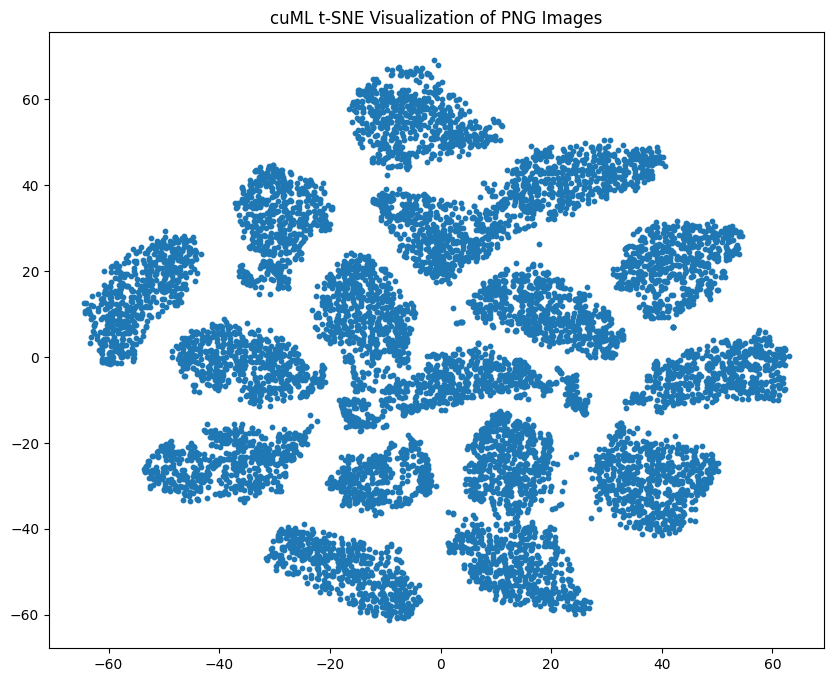

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)
plt.title("cuML t-SNE Visualization of PNG Images")
plt.show()


In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)


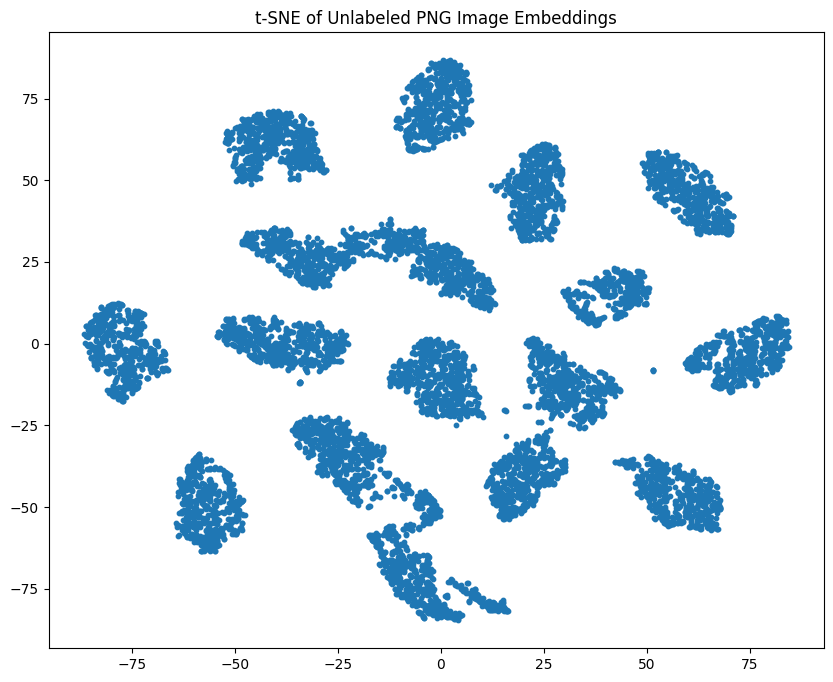

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)
plt.title("t-SNE of Unlabeled PNG Image Embeddings")
plt.show()


In [49]:
import pandas as pd

df = pd.DataFrame(tsne_result, columns=["x", "y"])
df["filename"] = file_names
df.to_csv("tsne_output.csv", index=False)


In [50]:
from cuml import UMAP
import cupy as cp

# Convert to cupy GPU array
embeddings_gpu = cp.asarray(embeddings)

# Initialize and run UMAP
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", verbose=1)
umap_result_gpu = umap.fit_transform(embeddings_gpu)

# Convert back to numpy
umap_result = cp.asnumpy(umap_result_gpu)


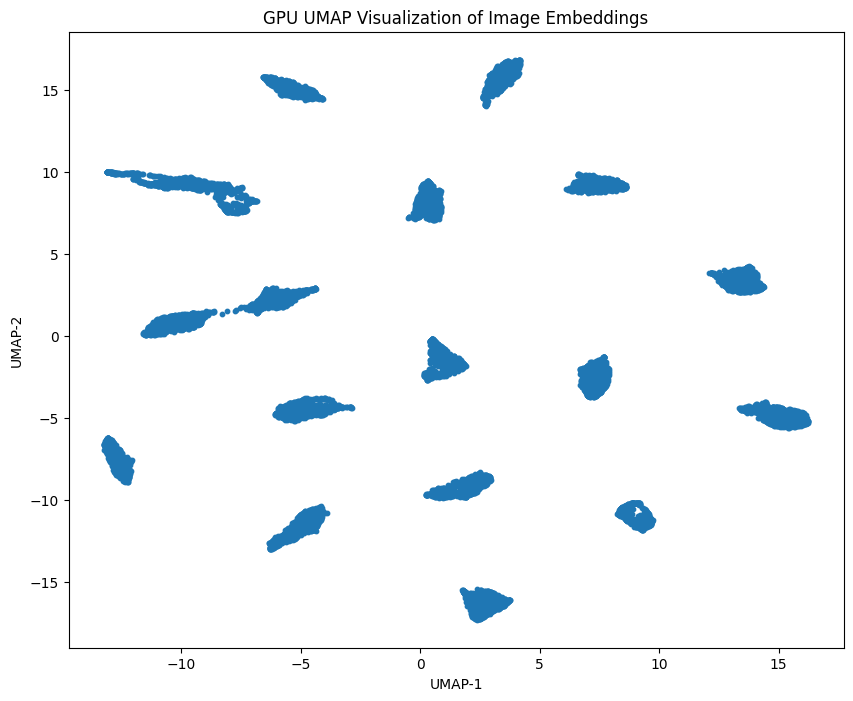

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], s=10)
plt.title("GPU UMAP Visualization of Image Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [28]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os

def plot_umap_with_thumbnails(umap_result, file_names, thumb_size=(32, 32), max_images=500):
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_title("UMAP Projection with Image Thumbnails")

    # Normalize coordinates for better spacing
    x_min, x_max = umap_result[:, 0].min(), umap_result[:, 0].max()
    y_min, y_max = umap_result[:, 1].min(), umap_result[:, 1].max()

    # Optionally limit number of thumbnails to avoid clutter
    indices = list(range(min(len(file_names), max_images)))

    for idx in indices:
        x, y = umap_result[idx]
        try:
            img = Image.open(file_names[idx]).convert("RGB")
            img = img.resize(thumb_size)
            imgbox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imgbox, (x, y), frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            print(f"Skipping {file_names[idx]}: {e}")
            continue

    ax.set_xlim(x_min - 5, x_max + 5)
    ax.set_ylim(y_min - 5, y_max + 5)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
# plot_umap_with_thumbnails(umap_result, file_names, thumb_size=(32, 32), max_images=1500)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Step 1: Define your custom model constructor
def resnet50_(in_channels, n_classes, dropout=0.5, weights=None):
    model = models.resnet50(weights=weights)
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=2048, out_features=512, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=512, out_features=64, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(64),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=64, out_features=n_classes, bias=True)
    )
    return model
folder_path = "data/output/png"

# Step 2: Load the .pth file and clean state_dict
pth_path = "yichen_model.pth"
checkpoint = torch.load(pth_path, map_location="cuda")

# If 'state_dict' is present, extract it
if "state_dict" in checkpoint:
    checkpoint = checkpoint["state_dict"]

# Remove 'module.' prefix if trained with DataParallel
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    new_k = k.replace("module.", "")
    new_state_dict[new_k] = v

# Step 3: Create model and load weights
model = resnet50_(in_channels=3, n_classes=17)  # Change in_channels or n_classes as per your use
model.load_state_dict(new_state_dict)
model.eval()

print("✅ Model loaded successfully.")


# Custom dataset to load all PNGs
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]  # return image path for tracking

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = UnlabeledImageDataset(folder_path, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False,pin_memory=True,num_workers=16)

model.eval()
model.to("cuda:4")
model.fc = nn.Sequential(*list(model.fc.children())[:6])

import torch
import numpy as np
from tqdm import tqdm

embeddings = []
file_names = []

with torch.no_grad():
    for inputs, paths in tqdm(loader):
        inputs = inputs.to("cuda:4")
        feats = model(inputs)
        embeddings.append(feats.cpu().numpy())
        file_names.extend(paths)

embeddings = np.vstack(embeddings)

from cuml.manifold import TSNE
import cupy as cp

# Convert to cupy for GPU acceleration
embeddings_gpu = cp.asarray(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne_result_gpu = tsne.fit_transform(embeddings_gpu)

# Convert back to numpy
tsne_result = cp.asnumpy(tsne_result_gpu)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)
plt.title("cuML t-SNE Visualization of PNG Images")
plt.show()



In [1]:
import torch

# Load the checkpoint
checkpoint = torch.load('yichen_model.pth', map_location='cpu')  # or 'cuda' if you want

# If it's a simple state_dict
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Print the keys (layer names) and shapes
for key, value in state_dict.items():
    print(f"Layer: {key} | Shape: {tuple(value.shape)}")


ModuleNotFoundError: No module named 'torch'